In [116]:
import torch
import torch.nn.functional as F
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
import json
from tqdm import tqdm
import gc
import pickle

import numpy as np
import pandas as pd

from imblearn.under_sampling import RandomUnderSampler 
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook", font_scale=1.25)
pd.set_option('display.max_colwidth', 128)
pd.set_option('display.max_columns', 500)

In [117]:
with open('preprocessed.pickle', 'rb') as handle:
    mydict = pickle.load(handle)
    
truth = mydict['truth']
segments = mydict['segments']
mm = mydict['m']

In [118]:
with open('aggrodue.pickle', 'rb') as handle:
    aggrodue = pickle.load(handle)

In [119]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def assessme(y_true, y_pred, printme=False):
    met = {}
    met['mae'] = mean_absolute_error(y_true, y_pred)
    met['mse'] = mean_squared_error(y_true, y_pred)
    met['rmse'] = np.sqrt(met['mse'])
    met['r2'] = r2_score(y_true, y_pred)
    n, k = len(y_true), 1
    met['adj_r2'] = 1 - (1 - met['r2']) * (n - 1) / (n - k - 1)
    if printme:
        print(f" MAE: {met['mae']}\n MSE: {met['mse']}\n RMSE: {met['rmse']}\n R²: {met['r2']}\n Adjusted R²: {met['adj_r2']}")
    return met

### semantic uncertainty (rao_l)

In [120]:
mm.run.max()

9

In [121]:
mm.segment.unique()

array(['preamble', 'instruction', 'input', 'question', 'postilla',
       'generated'], dtype=object)

In [122]:
# minimum number of generated tokens
mm[(mm.segment=='generated')].groupby('pid').tokzero.max().min()

13

In [123]:
%%time

# recover additional features (kl/iou)

mmg = mm[mm.segment=='generated']

df_logitlens_kl_expanded = mmg['logitlens_kl'].apply(pd.Series)
df_logitlens_kl_expanded.columns = [f'logitlens_kl{i}' for i in range(df_logitlens_kl_expanded.shape[1])]

df_logitlens_iou_expanded = mmg['logitlens_iou'].apply(pd.Series)
df_logitlens_iou_expanded.columns = [f'logitlens_iou{i}' for i in range(df_logitlens_iou_expanded.shape[1])]

# concat with the original
mmg = pd.concat([mmg.drop(columns=['logitlens_kl', 'logitlens_iou']),
                     df_logitlens_kl_expanded,
                     df_logitlens_iou_expanded], axis=1)

CPU times: user 15.9 s, sys: 373 ms, total: 16.3 s
Wall time: 16.3 s


In [239]:
# beginning of generation
N = 10

selected_features = ['true_ent', 'maxp']

# beginning of generation bears more information (AUC) than end of generation
ds = mmg[(mmg.segment=='generated') & (mmg.tokzero<N)][['run', 'pid', 'tokzero'] + selected_features]

ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=selected_features).reset_index()

# indexes for kl/iou are _LAYER_TOKEN
ds.columns = ['_'.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.rename(columns={'run_': 'run', 'pid_': 'pid'})
ds = ds.merge(truth, on=['run', 'pid'])

In [240]:
target = 'pe_rao_trans_s_norm' # 'pe_rao_trans_s' # 'answers_entropy_norm'
ds = ds.merge(aggrodue[['pid', target, 'correct_mean']], on='pid')

In [241]:
ds

,run,pid,true_ent_0,true_ent_1,true_ent_2,true_ent_3,true_ent_4,true_ent_5,true_ent_6,true_ent_7,true_ent_8,true_ent_9,maxp_0,maxp_1,maxp_2,maxp_3,maxp_4,maxp_5,maxp_6,maxp_7,maxp_8,maxp_9,correct,hallucinated,pe_rao_trans_s_norm,correct_mean
0,0,12,0.018685,5.970278e-07,1.343955e-05,0.000013,0.028989,6.291689e-01,2.370336e-08,0.000002,0.000138,2.169739e-05,0.997728,1.0,0.999999,0.999999,0.996175,0.726226,1.0,1.000000,0.99999,0.999999,False,False,4.915105e-01,0.2
1,1,12,0.018685,5.970278e-07,1.343955e-05,0.000013,0.028989,6.291689e-01,2.370336e-08,0.000002,0.000138,2.169739e-05,0.997728,1.0,0.999999,0.999999,0.996175,0.726226,1.0,1.000000,0.99999,0.999999,False,False,4.915105e-01,0.2
2,2,12,0.018685,5.970278e-07,1.343955e-05,0.000013,0.028989,6.291689e-01,2.370336e-08,0.000002,0.000138,2.169739e-05,0.997728,1.0,0.999999,0.999999,0.996175,0.726226,1.0,1.000000,0.99999,0.999999,False,False,4.915105e-01,0.2
3,3,12,0.018685,5.970278e-07,1.343955e-05,0.000013,0.028989,6.291689e-01,2.370336e-08,0.000002,0.000138,2.169739e-05,0.997728,1.0,0.999999,0.999999,0.996175,0.726226,1.0,1.000000,0.99999,0.999999,False,False,4.915105e-01,0.2
4,4,12,0.018685,5.970278e-07,1.343955e-05,0.000013,0.028989,6.291689e-01,2.370336e-08,0.000002,0.000138,2.169739e-05,0.997728,1.0,0.999999,0.999999,0.996175,0.726226,1.0,1.000000,0.99999,0.999999,False,False,4.915105e-01,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4935,5,1794,0.091260,2.654073e-07,4.844068e-07,0.000953,0.094541,6.896256e-08,3.257283e-06,0.000070,0.000002,1.988961e-08,0.984637,1.0,1.000000,0.999913,0.984707,1.000000,1.0,0.999995,1.00000,1.000000,True,False,2.220446e-16,1.0
4936,6,1794,0.091260,2.654073e-07,4.844068e-07,0.000953,0.094541,6.896256e-08,3.257283e-06,0.000070,0.000002,1.988961e-08,0.984637,1.0,1.000000,0.999913,0.984707,1.000000,1.0,0.999995,1.00000,1.000000,True,False,2.220446e-16,1.0
4937,7,1794,0.091260,2.654073e-07,4.844068e-07,0.000953,0.094541,6.896256e-08,3.257283e-06,0.000070,0.000002,1.988961e-08,0.984637,1.0,1.000000,0.999913,0.984707,1.000000,1.0,0.999995,1.00000,1.000000,True,False,2.220446e-16,1.0
4938,8,1794,0.091260,2.654073e-07,4.844068e-07,0.000953,0.094541,6.896256e-08,3.257283e-06,0.000070,0.000002,1.988961e-08,0.984637,1.0,1.000000,0.999913,0.984707,1.000000,1.0,0.999995,1.00000,1.000000,True,False,2.220446e-16,1.0


In [242]:
ds.correct.value_counts()

correct
True     3529
False    1411
Name: count, dtype: int64

In [243]:
# WARNING here we are dropping duplicates 
# include pid to have at least one example per prompt
# (include correct as variable since it embeds 'aleatoric uncertainty')
ds = ds.drop_duplicates(ds.columns[1:-3])

In [244]:
y = ds[target].round(2)
correct_mean_thr = ds.correct_mean > .5
correct_mean = ds.correct_mean
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated', target, 'correct_mean'])

In [245]:
X.loc[:,X.nunique()!=1].shape

(768, 20)

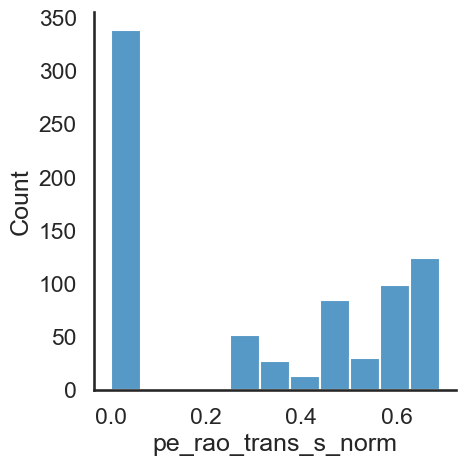

In [246]:
sns.displot(y)

In [247]:
X.isnull().sum().sum() == 0

True

In [248]:
# rus = RandomUnderSampler(random_state=42)
X_res, y_res = X, y # rus.fit_resample(X, y)
pids_res = pids # [y_res.index]

X_res.columns = ['generated_'+col for col in X.columns]

In [249]:
X_res.isnull().sum().sum() == 0

True

### beginning of generation, entropy

In [250]:
%%time

from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict

from xgboost import XGBRFRegressor, XGBRFClassifier
import xgboost


xgb_model = XGBRFRegressor(n_estimators=100, n_jobs=6)

# pred = cross_val_predict(xgb_model, X_res, y_res, cv=LeaveOneGroupOut(), groups=pids_res)
pred = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), groups=pids_res)

CPU times: user 5.6 s, sys: 1.7 s, total: 7.31 s
Wall time: 1.11 s


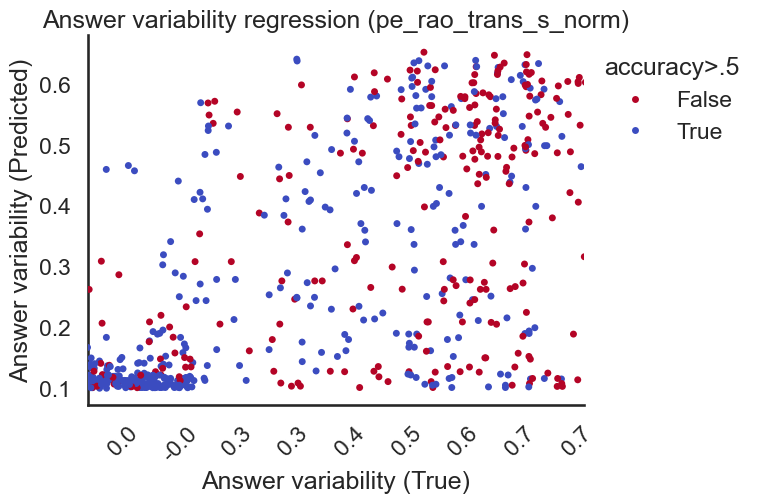

In [251]:
import matplotlib.colors as mcolors

norm = mcolors.PowerNorm(gamma=2, vmin=0, vmax=1)
cmap = plt.cm.coolwarm_r
colors = [mcolors.to_hex(cmap(norm(value))) for value in correct_mean]
palette = {val: col for val, col in zip(correct_mean, colors)}

ax = sns.stripplot(y=pred, x=np.round(y_res.values,1), 
                   jitter=1, 
                   hue=correct_mean_thr, 
                   size=5, 
                   palette = palette)
sns.despine()

plt.title(f'Answer variability regression ({target})')
plt.xlabel('Answer variability (True)')
plt.ylabel('Answer variability (Predicted)')

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False, title='accuracy>.5')

from matplotlib.ticker import MaxNLocator
ax.xaxis.set_major_locator(MaxNLocator(nbins=10))
plt.xticks(rotation=45)

plt.show()

In [252]:
met = assessme(y_res.values, pred)
met

{'mae': 0.17582164913377105,
 'mse': 0.05017037631150847,
 'rmse': 0.22398744677215388,
 'r2': 0.3702615240417675,
 'adj_r2': 0.3694394111488716}

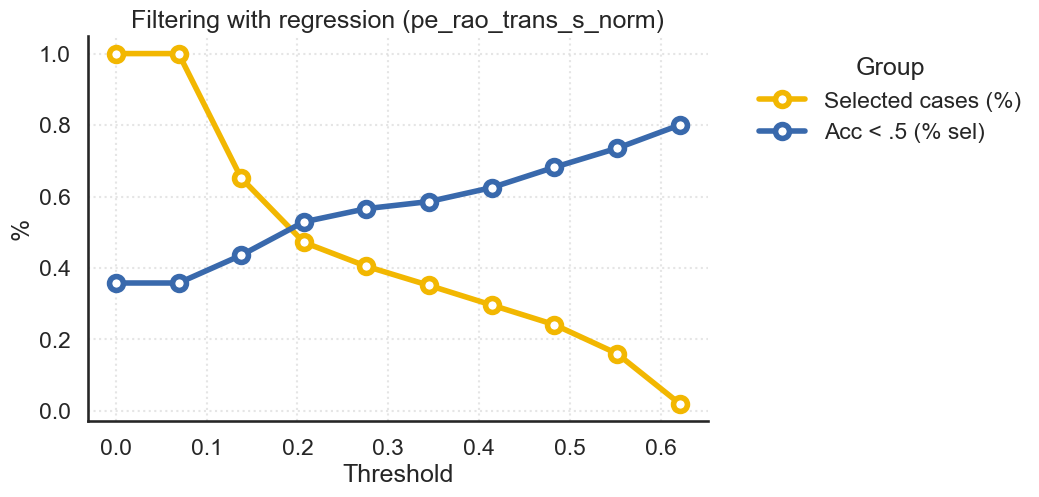

In [230]:
thresholds = np.linspace(y_res.min(), y_res.max(), 10, endpoint=False)
cases_rel = [(pred >= thr).sum() / pred.shape[0] for thr in thresholds]
unsure_count = [(~correct_mean_thr[pred>=thr]).sum() / (pred>=thr).sum() for thr in thresholds]

sns.set_context("talk")
sns.set_style("white")

from palettable.cartocolors.qualitative import Prism_10, Bold_10
from palettable.tableau import TrafficLight_9, BlueRed_12
palette = Bold_10.mpl_colors

# Create the plot
plt.figure(figsize=(8, 5))
ax = sns.lineplot(x=thresholds, y=cases_rel, label="Selected cases (%)", marker="o", color=palette[3], linewidth=10, linestyle='-')

ax = sns.lineplot(x=thresholds, y=unsure_count, label="Acc < .5 (% sel)", marker="o", color=palette[2], linewidth=10, linestyle='-')

for line in ax.lines:
    line.set_marker("o")
    line.set_markersize(10)
    line.set_markerfacecolor("white")
    line.set_markeredgewidth(4)
    line.set_linewidth(4)
    
ax.lines[0].set_markeredgecolor(palette[3])
ax.lines[1].set_markeredgecolor(palette[2])

# Labels and title
plt.xlabel("Threshold")
plt.ylabel("%")
plt.title(f"Filtering with regression ({target})")
plt.legend()
plt.grid(True)

plt.grid(True, linestyle="dotted", alpha=0.5)
plt.legend(title="Group", bbox_to_anchor=(1.05, 1), loc="upper left", frameon=False)
sns.despine()


# Show the plot
plt.show()

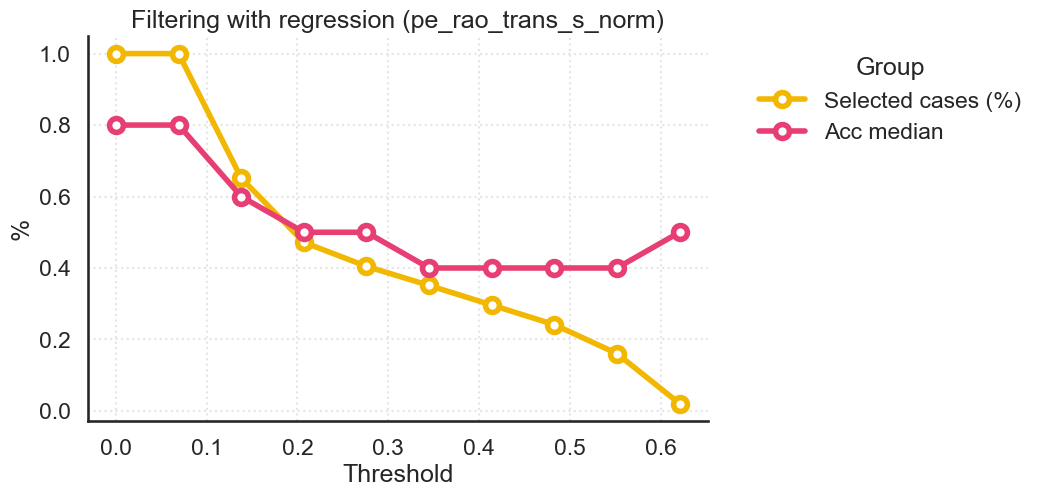

In [203]:
thresholds = np.linspace(y_res.min(), y_res.max(), 10, endpoint=False)
cases_rel = [(pred >= thr).sum() / pred.shape[0] for thr in thresholds]
unsure_count = [correct_mean[pred>=thr].median() for thr in thresholds]

sns.set_context("talk")
sns.set_style("white")

from palettable.cartocolors.qualitative import Prism_10, Bold_10
from palettable.tableau import TrafficLight_9, BlueRed_12
palette = Bold_10.mpl_colors

# Create the plot
plt.figure(figsize=(8, 5))
ax = sns.lineplot(x=thresholds, y=cases_rel, label="Selected cases (%)", marker="o", color=palette[3], linewidth=10, linestyle='-')

ax = sns.lineplot(x=thresholds, y=unsure_count, label="Acc median", marker="o", color=palette[4], linewidth=10, linestyle='-')

for line in ax.lines:
    line.set_marker("o")
    line.set_markersize(10)
    line.set_markerfacecolor("white")
    line.set_markeredgewidth(4)
    line.set_linewidth(4)
    
ax.lines[0].set_markeredgecolor(palette[3])
ax.lines[1].set_markeredgecolor(palette[4])

# Labels and title
plt.xlabel("Threshold")
plt.ylabel("%")
plt.title(f"Filtering with regression ({target})")
plt.legend()
plt.grid(True)

plt.grid(True, linestyle="dotted", alpha=0.5)
plt.legend(title="Group", bbox_to_anchor=(1.05, 1), loc="upper left", frameon=False)
sns.despine()


# Show the plot
plt.show()

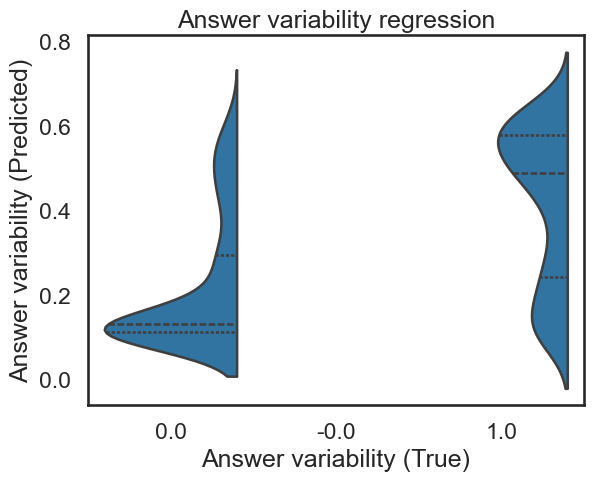

In [177]:
ax = sns.violinplot(y=pred, x=np.round(y_res.values,0), 
                    split=True, inner="quart", width=0.8) # , log_scale=(True,False))

plt.title('Answer variability regression')
plt.xlabel('Answer variability (True)')
plt.ylabel('Answer variability (Predicted)')

plt.show()

### answers entropy

In [184]:
# beginning of generation
N = 10

selected_features = ['true_ent', 'maxp']

# beginning of generation bears more information (AUC) than end of generation
ds = mmg[(mmg.segment=='generated') & (mmg.tokzero<N)][['run', 'pid', 'tokzero'] + selected_features]

ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=selected_features).reset_index()

# indexes for kl/iou are _LAYER_TOKEN
ds.columns = ['_'.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.rename(columns={'run_': 'run', 'pid_': 'pid'})
ds = ds.merge(truth, on=['run', 'pid'])

target = 'answers_entropy_norm' # 'pe_rao_trans_s' # 'answers_entropy_norm'
ds = ds.merge(aggrodue[['pid', target, 'correct_mean']], on='pid')

# WARNING here we are dropping duplicates 
# include pid to have at least one example per prompt
# (include correct as variable since it embeds 'aleatoric uncertainty')
ds = ds.drop_duplicates(ds.columns[1:-3])

y = ds[target].round(2)
correct_mean_thr = ds.correct_mean > .5
correct_mean = ds.correct_mean
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated', target, 'correct_mean'])

X_res, y_res = X, y # rus.fit_resample(X, y)
pids_res = pids # [y_res.index]

X_res.columns = ['generated_'+col for col in X.columns]

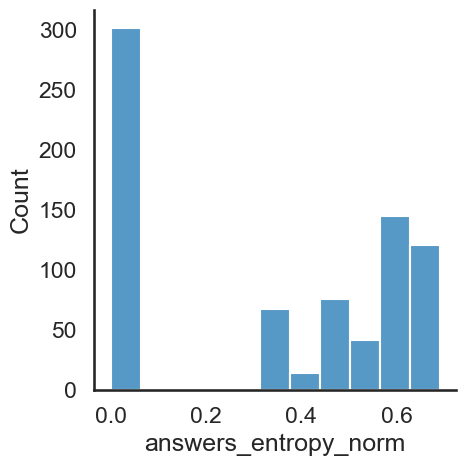

In [185]:
sns.displot(y)

In [186]:
%%time

from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict

from xgboost import XGBRFRegressor, XGBRFClassifier
import xgboost


xgb_model = XGBRFRegressor(n_estimators=100, n_jobs=6)

# pred = cross_val_predict(xgb_model, X_res, y_res, cv=LeaveOneGroupOut(), groups=pids_res)
pred = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), groups=pids_res)

CPU times: user 4.81 s, sys: 1.5 s, total: 6.31 s
Wall time: 1 s


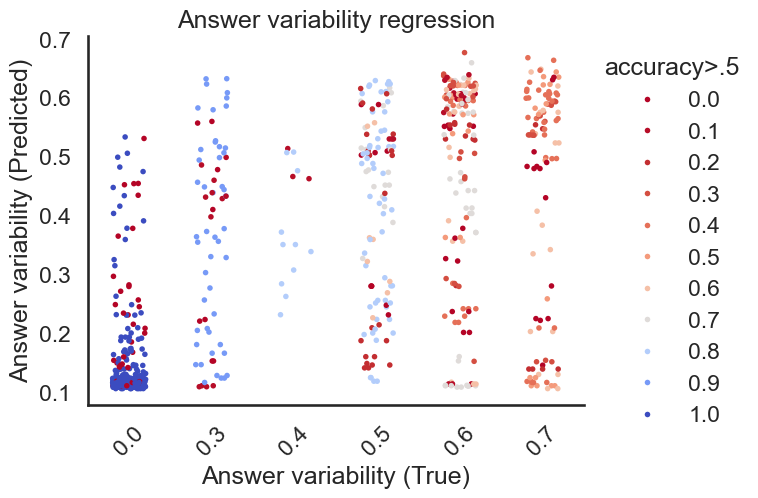

In [187]:
norm = mcolors.PowerNorm(gamma=2, vmin=0, vmax=1)
cmap = plt.cm.coolwarm_r
colors = [mcolors.to_hex(cmap(norm(value))) for value in correct_mean]
palette = {val: col for val, col in zip(correct_mean, colors)}

ax = sns.stripplot(y=pred, x=np.round(y_res.values,1), jitter=0.2, hue=correct_mean, size=4, palette=palette) # , log_scale=(True,False))
sns.despine()

plt.title('Answer variability regression')
plt.xlabel('Answer variability (True)')
plt.ylabel('Answer variability (Predicted)')

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False, title='accuracy>.5')

#from matplotlib.ticker import MaxNLocator
#ax.xaxis.set_major_locator(MaxNLocator(nbins=10))
plt.xticks(rotation=45)

plt.show()

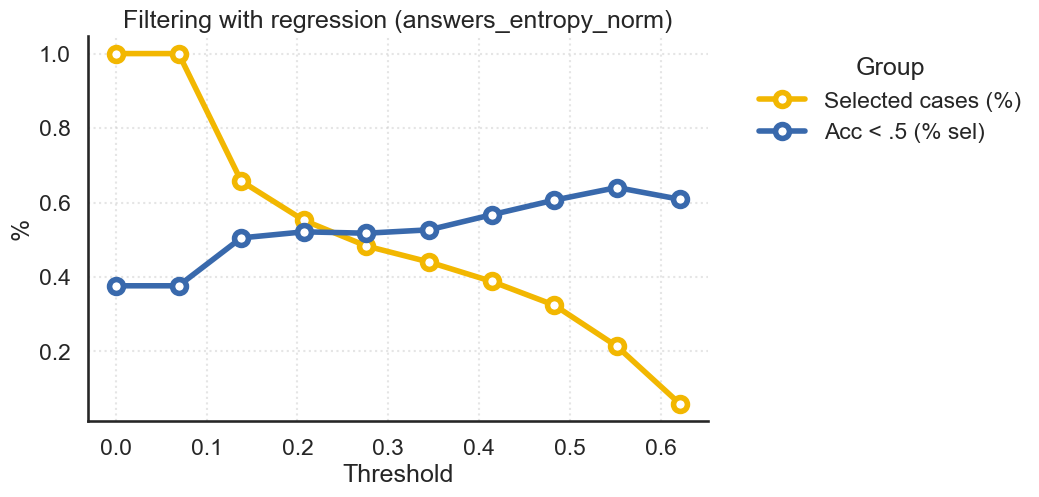

In [188]:
thresholds = np.linspace(y_res.min(), y_res.max(), 10, endpoint=False)
cases_rel = [(pred > thr).sum() / pred.shape[0] for thr in thresholds]
unsure_count = [(~correct_mean_thr[pred>thr]).sum() / (pred>thr).sum() for thr in thresholds]

sns.set_context("talk")
sns.set_style("white")

from palettable.cartocolors.qualitative import Prism_10, Bold_10
from palettable.tableau import TrafficLight_9, BlueRed_12
palette = Bold_10.mpl_colors

# Create the plot
plt.figure(figsize=(8, 5))
ax = sns.lineplot(x=thresholds, y=cases_rel, label="Selected cases (%)", marker="o", color=palette[3], linewidth=10, linestyle='-')

ax = sns.lineplot(x=thresholds, y=unsure_count, label="Acc < .5 (% sel)", marker="o", color=palette[2], linewidth=10, linestyle='-')

for line in ax.lines:
    line.set_marker("o")
    line.set_markersize(10)
    line.set_markerfacecolor("white")
    line.set_markeredgewidth(4)
    line.set_linewidth(4)
    
ax.lines[0].set_markeredgecolor(palette[3])
ax.lines[1].set_markeredgecolor(palette[2])

# Labels and title
plt.xlabel("Threshold")
plt.ylabel("%")
plt.title(f"Filtering with regression ({target})")
plt.legend()
plt.grid(True)

plt.grid(True, linestyle="dotted", alpha=0.5)
plt.legend(title="Group", bbox_to_anchor=(1.05, 1), loc="upper left", frameon=False)
sns.despine()


# Show the plot
plt.show()

In [32]:
met = assessme(y_res.values, pred)
met

{'mae': 0.16051950023587172,
 'mse': 0.04325667585340909,
 'rmse': 0.2079823931331907,
 'r2': 0.4581886274981646,
 'adj_r2': 0.45748130194659564}

In [33]:
set(np.round(y_res.values,2).astype(str))

{'0.0',
 '0.33',
 '0.4',
 '0.5',
 '0.51',
 '0.54',
 '0.57',
 '0.58',
 '0.59',
 '0.6',
 '0.61',
 '0.64',
 '0.65',
 '0.66',
 '0.67',
 '0.68',
 '0.69'}

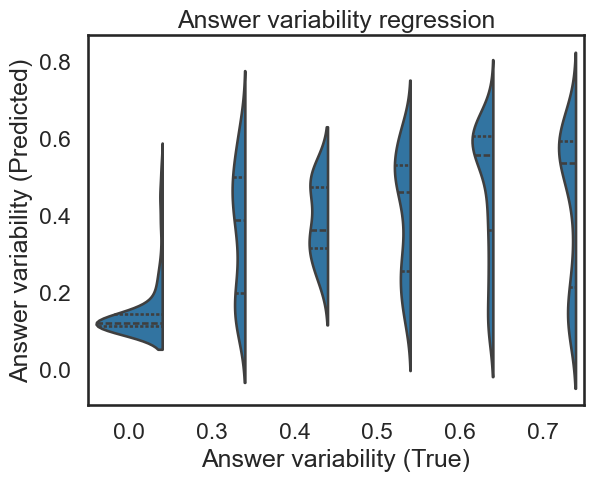

In [34]:
ax = sns.violinplot(y=pred, x=np.round(y_res.values,1), 
                    split=True, inner="quart", width=0.8) # , log_scale=(True,False))


plt.title('Answer variability regression')
plt.xlabel('Answer variability (True)')
plt.ylabel('Answer variability (Predicted)')

plt.show()

In [35]:
import xgboost
import shap

model = xgboost.XGBRegressor(n_estimators=100).fit(X_res, y_res)
explainer = shap.Explainer(model, X_res)
shap_values = explainer(X_res)

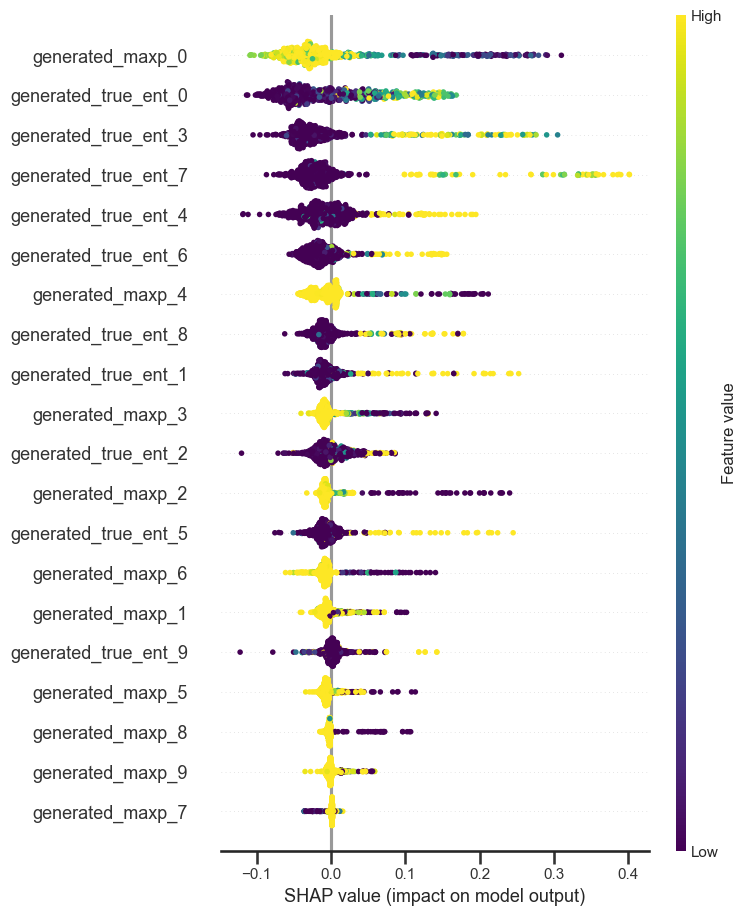

In [36]:
shap.summary_plot(shap_values, X_res, cmap="viridis")

In [37]:
# https://github.com/shap/shap/blob/master/shap/plots/_bar.py
c = shap_values.abs.mean(0)
features = c.display_data if c.display_data is not None else c.data
feature_names = c.feature_names
op_history = c.op_history
values = np.array([c.values])
vals = pd.DataFrame({'label':shap_values.feature_names, 'value':values[0]}).sort_values('value', ascending=False)
vals.value = vals.value / vals.value.sum()
vals['label_orig'] = vals['label']
vals['grp'] = vals['label'].apply(lambda x : ''.join(i for i in x if not i.isdigit()))
# vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x if i.isdigit()))
vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x.split('_')[-1] if i.isdigit()))
vals['label'] = vals['label'].astype(int)

In [38]:
vals.groupby('grp').value.sum()

grp
generated_maxp_        0.371403
generated_true_ent_    0.628597
Name: value, dtype: float64



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



<Axes: xlabel='label', ylabel='value'>

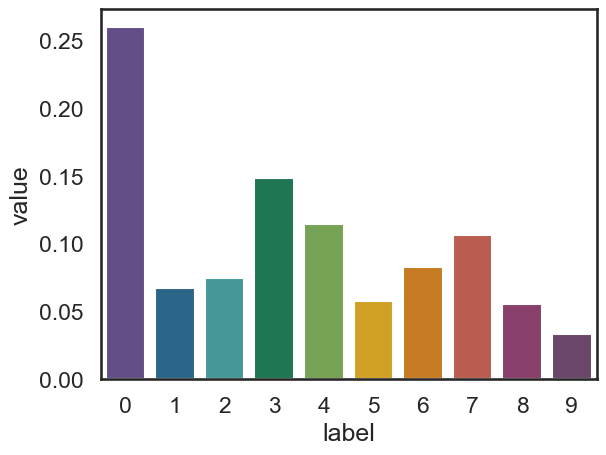

In [39]:
from palettable.cartocolors.qualitative import Prism_10, Bold_10
palette = Prism_10.mpl_colors 

index_importances = vals.sort_index().groupby('label').value.sum()

sns.barplot(index_importances, palette=palette)

Text(33.22569444444443, 0.5, 'Token index')

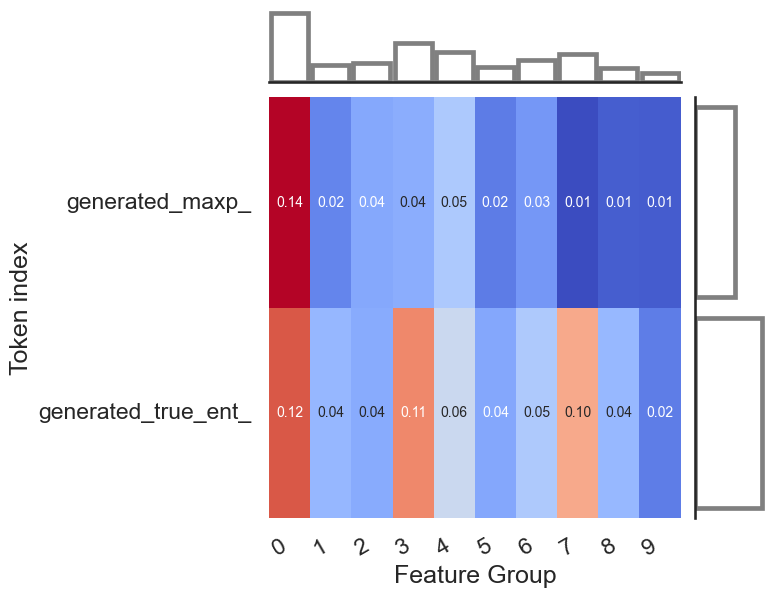

In [40]:
_toplot = vals.pivot(index='grp', columns='label', values='value')

grid = sns.JointGrid()

# Fill the centre with our heatmap
sns.heatmap(_toplot, ax=grid.ax_joint, cbar=False, annot=True, fmt=".2f", annot_kws={"fontsize":10}, cmap="coolwarm")
# Draw total bars, both with width 1, but the Y one with horizontal orientation

sns.barplot(_toplot.sum(), ax=grid.ax_marg_x, width=0.9, fill=False, color='grey')

sns.barplot(_toplot.sum(axis=1), ax=grid.ax_marg_y, orient='h', width=0.9, fill=False, color='grey')
# Offset value (just half an unit)
_off = .5

# Fix x
_xmin, _xmax = grid.ax_joint.get_xlim()
grid.ax_joint.set_xlim(_xmin+_off, _xmax+_off)
for bar in grid.ax_marg_x.containers[0]:
    bar.set_x(bar.get_x() + _off)

# Fix y
_ymin, _ymax = grid.ax_joint.get_ylim()
grid.ax_joint.set_ylim(_ymin+_off, _ymax+_off)
for bar in grid.ax_marg_y.containers[0]:
    bar.set_y(bar.get_y() + _off)

# Need to use this to set the horizontal_alignment
grid.ax_joint.set_xticklabels(
    grid.ax_joint.get_xticklabels(), 
    rotation=30,    
    ha='right'
)
grid.ax_joint.yaxis.set_tick_params(rotation=0)

grid.ax_joint.set_xlabel('Feature Group')
grid.ax_joint.set_ylabel('Token index')

### all features

In [253]:
# beginning of generation
N = 10

selected_features = ['true_ent', 'maxp'] + list(df_logitlens_kl_expanded.columns) + list(df_logitlens_iou_expanded.columns)

# beginning of generation bears more information (AUC) than end of generation
ds = mmg[(mmg.segment=='generated') & (mmg.tokzero<N)][['run', 'pid', 'tokzero'] + selected_features]

ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=selected_features).reset_index()

# indexes for kl/iou are _LAYER_TOKEN
ds.columns = ['_'.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.rename(columns={'run_': 'run', 'pid_': 'pid'})
ds = ds.merge(truth, on=['run', 'pid'])

target = 'pe_rao_trans_s_norm' # 'pe_rao_trans_s' # 'answers_entropy_norm'
ds = ds.merge(aggrodue[['pid', target, 'correct_mean']], on='pid')

# WARNING here we are dropping duplicates (include correct as variable since it embeds 'aleatoric uncertainty')
ds = ds.drop_duplicates(ds.columns[1:-3])

y = ds[target].round(2)
correct_mean = ds.correct_mean > 0.5
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated', target, 'correct_mean'])

# rus = RandomUnderSampler(random_state=42)
X_res, y_res = X, y # rus.fit_resample(X, y)
pids_res = pids # [y_res.index]

X_res.columns = ['generated_'+col for col in X.columns]

In [254]:
X_res.shape

(768, 660)

In [255]:
%%time

from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict

from xgboost import XGBRFRegressor, XGBRFClassifier
import xgboost


xgb_model = XGBRFRegressor(n_estimators=100, n_jobs=6)

# pred = cross_val_predict(xgb_model, X_res, y_res, cv=LeaveOneGroupOut(), groups=pids_res)
pred = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), groups=pids_res)

CPU times: user 1min 30s, sys: 6.3 s, total: 1min 36s
Wall time: 18.8 s


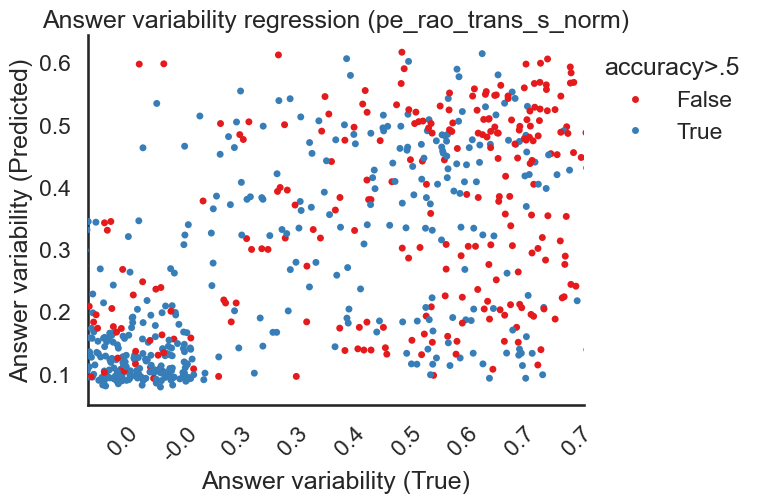

In [256]:
ax = sns.stripplot(y=pred, x=np.round(y_res.values,1), 
                   jitter=1, 
                   hue=correct_mean, 
                   size=5, 
                   palette='Set1') # , log_scale=(True,False))
sns.despine()

plt.title(f'Answer variability regression ({target})')
plt.xlabel('Answer variability (True)')
plt.ylabel('Answer variability (Predicted)')

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False, title='accuracy>.5')

from matplotlib.ticker import MaxNLocator
ax.xaxis.set_major_locator(MaxNLocator(nbins=10))
plt.xticks(rotation=45)

plt.show()

In [257]:
met = assessme(y_res.values, pred)
met

{'mae': 0.18762963293236679,
 'mse': 0.05247434595429562,
 'rmse': 0.22907279618997892,
 'r2': 0.34134210110393315,
 'adj_r2': 0.34048223439519154}

In [46]:
%%time

import xgboost
import shap

model = xgboost.XGBRegressor(n_estimators=100, booster='gblinear').fit(X_res, y_res)
explainer = shap.Explainer(model, X_res)
shap_values = explainer(X_res)

CPU times: user 1.61 s, sys: 507 ms, total: 2.12 s
Wall time: 379 ms


In [47]:
# https://github.com/shap/shap/blob/master/shap/plots/_bar.py
c = shap_values.abs.mean(0)
features = c.display_data if c.display_data is not None else c.data
feature_names = c.feature_names
op_history = c.op_history
values = np.array([c.values])
vals = pd.DataFrame({'label':shap_values.feature_names, 'value':values[0]}).sort_values('value', ascending=False)
vals.value = vals.value / vals.value.sum()
vals['label_orig'] = vals['label']
vals['grp'] = vals['label'].apply(lambda x : ''.join(i for i in x if not i.isdigit()))
# vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x if i.isdigit()))
vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x.split('_')[-1] if i.isdigit()))
vals['label'] = vals['label'].astype(int)

vals.groupby('grp').value.sum()

grp
generated_logitlens_iou_    0.371901
generated_logitlens_kl_     0.543722
generated_maxp_             0.003055
generated_true_ent_         0.081322
Name: value, dtype: float64

In [48]:
vals

,label,value,label_orig,grp
0,0,0.019697,generated_true_ent_0,generated_true_ent_
225,5,0.015712,generated_logitlens_kl20_5,generated_logitlens_kl_
3,3,0.014979,generated_true_ent_3,generated_true_ent_
6,6,0.014899,generated_true_ent_6,generated_true_ent_
235,5,0.012502,generated_logitlens_kl21_5,generated_logitlens_kl_
...,...,...,...,...
348,8,0.000000,generated_logitlens_iou0_8,generated_logitlens_iou_
416,6,0.000000,generated_logitlens_iou7_6,generated_logitlens_iou_
417,7,0.000000,generated_logitlens_iou7_7,generated_logitlens_iou_
461,1,0.000000,generated_logitlens_iou12_1,generated_logitlens_iou_


Text(33.22569444444443, 0.5, 'Token index')

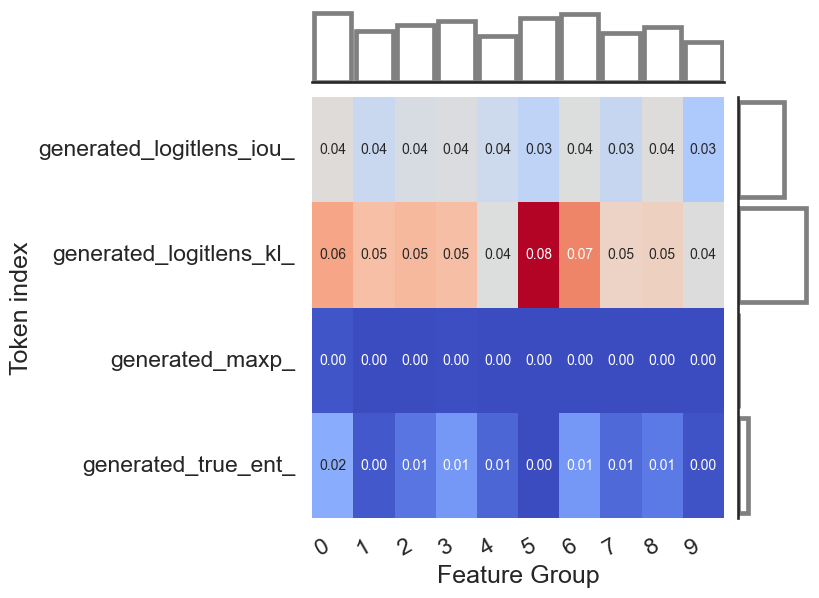

In [49]:
_toplot = vals.pivot_table(index=['grp'], columns='label', values='value', aggfunc='sum')

grid = sns.JointGrid()

# Fill the centre with our heatmap
sns.heatmap(_toplot, ax=grid.ax_joint, cbar=False, annot=True, fmt=".2f", annot_kws={"fontsize":10}, cmap="coolwarm")
# Draw total bars, both with width 1, but the Y one with horizontal orientation

sns.barplot(_toplot.sum(), ax=grid.ax_marg_x, width=0.9, fill=False, color='grey')

sns.barplot(_toplot.sum(axis=1), ax=grid.ax_marg_y, orient='h', width=0.9, fill=False, color='grey')

# Offset value (just half an unit)
_off = .5

# Fix x
_xmin, _xmax = grid.ax_joint.get_xlim()
grid.ax_joint.set_xlim(_xmin+_off, _xmax+_off)
for bar in grid.ax_marg_x.containers[0]:
    bar.set_x(bar.get_x() + _off)

# Fix y
_ymin, _ymax = grid.ax_joint.get_ylim()
grid.ax_joint.set_ylim(_ymin+_off, _ymax+_off)
for bar in grid.ax_marg_y.containers[0]:
    bar.set_y(bar.get_y() + _off)

# Need to use this to set the horizontal_alignment
grid.ax_joint.set_xticklabels(
    grid.ax_joint.get_xticklabels(), 
    rotation=30,    
    ha='right'
)
grid.ax_joint.yaxis.set_tick_params(rotation=0)

grid.ax_joint.set_xlabel('Feature Group')
grid.ax_joint.set_ylabel('Token index')

### only kl

In [50]:
# beginning of generation
N = 10

# selected_features = ['true_ent', 'maxp'] # + list(df_logitlens_kl_expanded.columns) + list(df_logitlens_iou_expanded.columns)
selected_features = list(df_logitlens_kl_expanded.columns)

#selected_features = ['true_ent', 'maxp']

# beginning of generation bears more information (AUC) than end of generation
ds = mmg[(mmg.segment=='generated') & (mmg.tokzero<N)][['run', 'pid', 'tokzero'] + selected_features]

ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=selected_features).reset_index()

# indexes for kl/iou are _LAYER_TOKEN
ds.columns = ['_'.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.rename(columns={'run_': 'run', 'pid_': 'pid'})
ds = ds.merge(truth, on=['run', 'pid'])

target = 'pe_rao_trans_s' # 'pe_rao_trans_s' # 'answers_entropy_norm'
ds = ds.merge(aggrodue[['pid', target, 'correct_mean']], on='pid')

# WARNING here we are dropping duplicates (include correct as variable since it embeds 'aleatoric uncertainty')
ds = ds.drop_duplicates(ds.columns[1:-3])

y = ds[target].round(2)
correct_mean = ds.correct_mean > 0.5
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated', target, 'correct_mean'])

# rus = RandomUnderSampler(random_state=42)
X_res, y_res = X, y # rus.fit_resample(X, y)
pids_res = pids # [y_res.index]

X_res.columns = ['generated_'+col for col in X.columns]

In [51]:
%%time

from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict

from xgboost import XGBRFRegressor, XGBRFClassifier
import xgboost


xgb_model = XGBRFRegressor(n_estimators=100, n_jobs=6)

# pred = cross_val_predict(xgb_model, X_res, y_res, cv=LeaveOneGroupOut(), groups=pids_res)
pred = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), groups=pids_res)

CPU times: user 46.3 s, sys: 8.08 s, total: 54.4 s
Wall time: 11.3 s


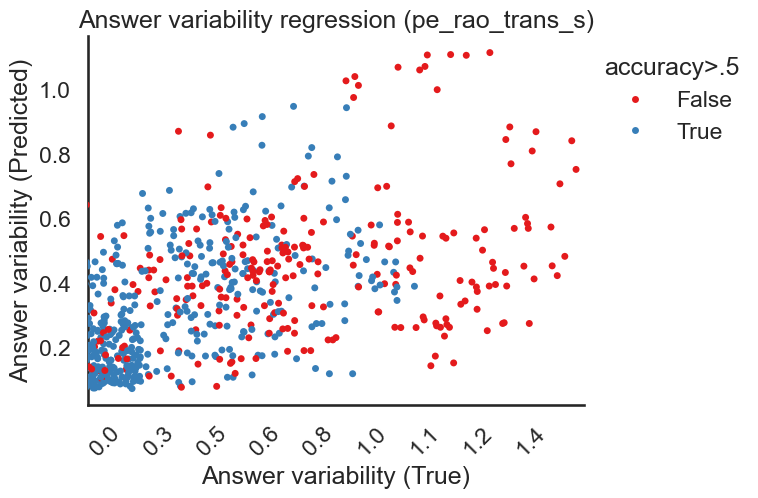

In [52]:
ax = sns.stripplot(y=pred, x=np.round(y_res.values,1), 
                   jitter=1, 
                   hue=correct_mean, 
                   size=5, 
                   palette='Set1') # , log_scale=(True,False))
sns.despine()

plt.title(f'Answer variability regression ({target})')
plt.xlabel('Answer variability (True)')
plt.ylabel('Answer variability (Predicted)')

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False, title='accuracy>.5')

from matplotlib.ticker import MaxNLocator
ax.xaxis.set_major_locator(MaxNLocator(nbins=10))
plt.xticks(rotation=45)

plt.show()

In [53]:
met = assessme(y_res.values, pred)
met

{'mae': 0.28840599951062657,
 'mse': 0.13233059018475976,
 'rmse': 0.3637727177576127,
 'r2': 0.25078950417177137,
 'adj_r2': 0.24981142258452826}

invalid value encountered in scalar divide


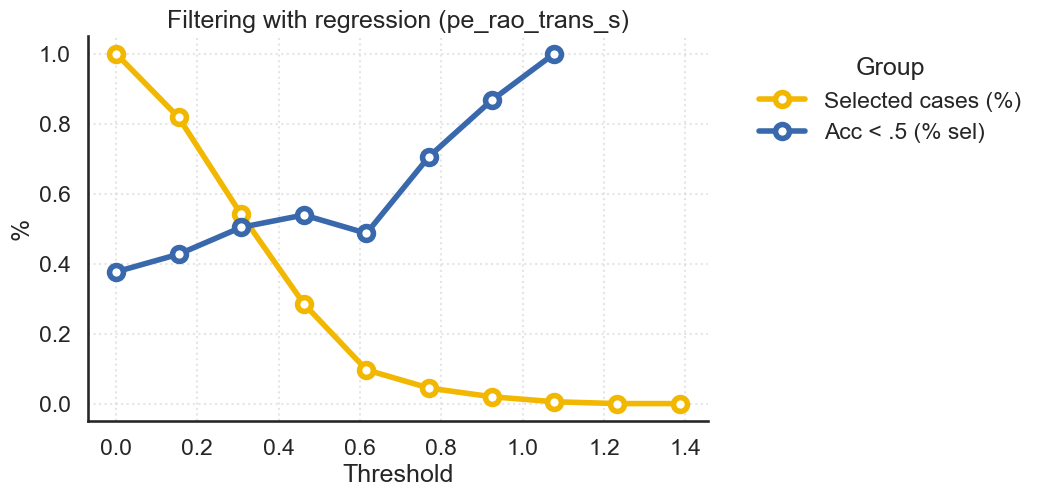

In [54]:
thresholds = np.linspace(y_res.min(), y_res.max(), 10, endpoint=False)
cases_rel = [(pred >= thr).sum() / pred.shape[0] for thr in thresholds]
unsure_count = [(~correct_mean[pred>=thr]).sum() / (pred>=thr).sum() for thr in thresholds]

sns.set_context("talk")
sns.set_style("white")

from palettable.cartocolors.qualitative import Prism_10, Bold_10
from palettable.tableau import TrafficLight_9, BlueRed_12
palette = Bold_10.mpl_colors

# Create the plot
plt.figure(figsize=(8, 5))
ax = sns.lineplot(x=thresholds, y=cases_rel, label="Selected cases (%)", marker="o", color=palette[3], linewidth=10, linestyle='-')

ax = sns.lineplot(x=thresholds, y=unsure_count, label="Acc < .5 (% sel)", marker="o", color=palette[2], linewidth=10, linestyle='-')

for line in ax.lines:
    line.set_marker("o")
    line.set_markersize(10)
    line.set_markerfacecolor("white")
    line.set_markeredgewidth(4)
    line.set_linewidth(4)
    
ax.lines[0].set_markeredgecolor(palette[3])
ax.lines[1].set_markeredgecolor(palette[2])

# Labels and title
plt.xlabel("Threshold")
plt.ylabel("%")
plt.title(f"Filtering with regression ({target})")
plt.legend()
plt.grid(True)

plt.grid(True, linestyle="dotted", alpha=0.5)
plt.legend(title="Group", bbox_to_anchor=(1.05, 1), loc="upper left", frameon=False)
sns.despine()


# Show the plot
plt.show()

In [55]:
import xgboost
import shap

model = xgboost.XGBRegressor(n_estimators=100).fit(X_res, y_res)
explainer = shap.Explainer(model, X_res)
shap_values = explainer(X_res)

In [56]:
# ONLY for layer-wise drilldown!
# grp in the layer

# https://github.com/shap/shap/blob/master/shap/plots/_bar.py
c = shap_values.abs.mean(0)
features = c.display_data if c.display_data is not None else c.data
feature_names = c.feature_names
op_history = c.op_history
values = np.array([c.values])
vals = pd.DataFrame({'label':shap_values.feature_names, 'value':values[0]}).sort_values('value', ascending=False)
vals.value = vals.value / vals.value.sum()
vals['label_orig'] = vals['label']
vals['grp'] = vals['label'].apply(lambda x : int(''.join(i for i in x.split('_')[-2] if i.isdigit())))
# vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x if i.isdigit()))
vals['label'] = vals['label'].apply(lambda x : int(''.join(i for i in x.split('_')[-1] if i.isdigit())))
vals['label'] = vals['label'].astype(int)

# vals.groupby('grp').value.sum()

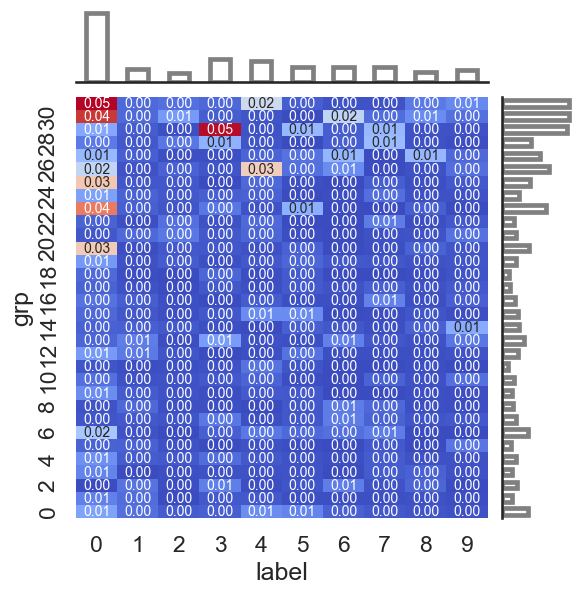

In [57]:
_toplot = vals.pivot_table(index=['grp'], columns='label', values='value', aggfunc='sum')

grid = sns.JointGrid()

# Fill the centre with our heatmap
sns.heatmap(_toplot, ax=grid.ax_joint, cbar=False, annot=True, fmt=".2f", annot_kws={"fontsize":10}, cmap="coolwarm")

sns.barplot(_toplot.sum(), ax=grid.ax_marg_x, width=0.5, fill=False, color='grey')
grid.ax_joint.set_ylim(0, 10)

sns.barplot(_toplot.sum(axis=1), ax=grid.ax_marg_y, orient='h', width=0.5, fill=False, color='grey')
grid.ax_joint.set_ylim(0, 32)

# Offset value (just half an unit)
_off = .5

_xmin, _xmax = grid.ax_joint.get_xlim()
grid.ax_joint.set_xlim(_xmin+_off, _xmax+_off)
for bar in grid.ax_marg_x.containers[0]:
    bar.set_x(bar.get_x() + _off)


# Fix y
# _ymin, _ymax = grid.ax_joint.get_ylim()
# grid.ax_joint.set_ylim(_ymin+_off, _ymax+_off)
for bar in grid.ax_marg_y.containers[0]:
    bar.set_y(bar.get_y() + _off)

In [58]:
list(vals.sort_values('value', ascending=False)[:5].label_orig)

['generated_logitlens_kl31_0',
 'generated_logitlens_kl29_3',
 'generated_logitlens_kl30_0',
 'generated_logitlens_kl23_0',
 'generated_logitlens_kl25_0']

### only best kl features with original ones

In [59]:
# beginning of generation
N = 10

selected_features = ['true_ent'] + list(df_logitlens_kl_expanded.columns)


# beginning of generation bears more information (AUC) than end of generation
ds = mmg[(mmg.segment=='generated') & (mmg.tokzero<N)][['run', 'pid', 'tokzero'] + selected_features]

ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=selected_features).reset_index()

# indexes for kl/iou are _LAYER_TOKEN
ds.columns = ['_'.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.rename(columns={'run_': 'run', 'pid_': 'pid'})
ds = ds.merge(truth, on=['run', 'pid'])

target = 'pe_rao_trans_s' # 'pe_rao_trans_s' # 'answers_entropy_norm'
ds = ds.merge(aggrodue[['pid', target, 'correct_mean']], on='pid')

# WARNING here we are dropping duplicates (include correct as variable since it embeds 'aleatoric uncertainty')
ds = ds.drop_duplicates(ds.columns[1:-3])

besties = ['logitlens_kl30_1',
 'logitlens_kl25_1',
 'logitlens_kl9_0',
 'logitlens_kl17_0',
 'logitlens_kl22_1']

ds = ds[[c for c in ds.columns if c in besties or 'logitlens' not in c]]

y = ds[target].round(2)
correct_mean = ds.correct_mean > 0.5
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated', target, 'correct_mean'])

# rus = RandomUnderSampler(random_state=42)
X_res, y_res = X, y # rus.fit_resample(X, y)
pids_res = pids # [y_res.index]

X_res.columns = ['generated_'+col for col in X.columns]

In [60]:
%%time

from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict

from xgboost import XGBRFRegressor, XGBRFClassifier
import xgboost


xgb_model = XGBRFRegressor(n_estimators=100, n_jobs=6)

# pred = cross_val_predict(xgb_model, X_res, y_res, cv=LeaveOneGroupOut(), groups=pids_res)
pred = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), groups=pids_res)

CPU times: user 4.63 s, sys: 2.73 s, total: 7.35 s
Wall time: 2.88 s


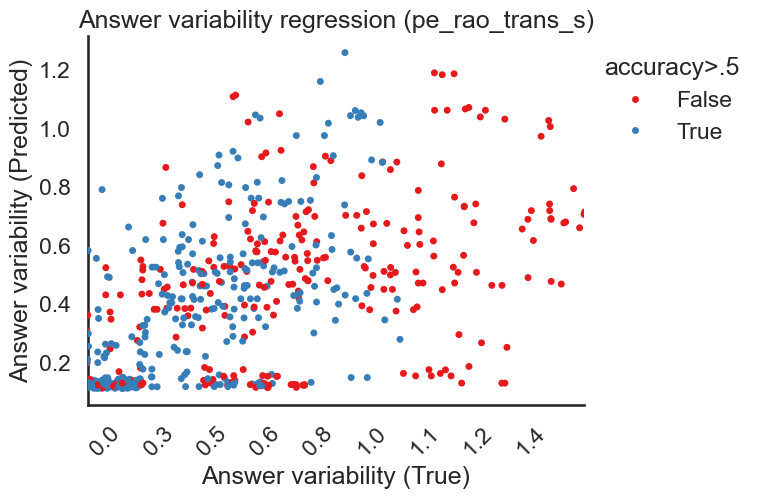

In [61]:
ax = sns.stripplot(y=pred, x=np.round(y_res.values,1), 
                   jitter=1, 
                   hue=correct_mean, 
                   size=5, 
                   palette='Set1') # , log_scale=(True,False))
sns.despine()

plt.title(f'Answer variability regression ({target})')
plt.xlabel('Answer variability (True)')
plt.ylabel('Answer variability (Predicted)')

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False, title='accuracy>.5')

from matplotlib.ticker import MaxNLocator
ax.xaxis.set_major_locator(MaxNLocator(nbins=10))
plt.xticks(rotation=45)

plt.show()

In [62]:
met = assessme(y_res.values, pred)
met

{'mae': 0.2534903491206933,
 'mse': 0.11170531875835908,
 'rmse': 0.33422345632579276,
 'r2': 0.36756272954914215,
 'adj_r2': 0.36673709342583816}

invalid value encountered in scalar divide


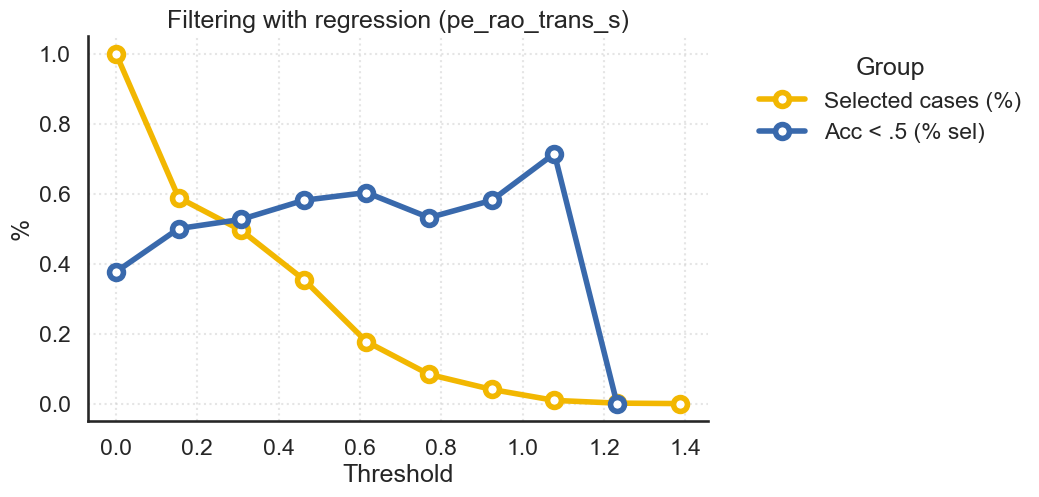

In [63]:
thresholds = np.linspace(y_res.min(), y_res.max(), 10, endpoint=False)
cases_rel = [(pred >= thr).sum() / pred.shape[0] for thr in thresholds]
unsure_count = [(~correct_mean[pred>=thr]).sum() / (pred>=thr).sum() for thr in thresholds]

sns.set_context("talk")
sns.set_style("white")

from palettable.cartocolors.qualitative import Prism_10, Bold_10
from palettable.tableau import TrafficLight_9, BlueRed_12
palette = Bold_10.mpl_colors

# Create the plot
plt.figure(figsize=(8, 5))
ax = sns.lineplot(x=thresholds, y=cases_rel, label="Selected cases (%)", marker="o", color=palette[3], linewidth=10, linestyle='-')

ax = sns.lineplot(x=thresholds, y=unsure_count, label="Acc < .5 (% sel)", marker="o", color=palette[2], linewidth=10, linestyle='-')

for line in ax.lines:
    line.set_marker("o")
    line.set_markersize(10)
    line.set_markerfacecolor("white")
    line.set_markeredgewidth(4)
    line.set_linewidth(4)
    
ax.lines[0].set_markeredgecolor(palette[3])
ax.lines[1].set_markeredgecolor(palette[2])

# Labels and title
plt.xlabel("Threshold")
plt.ylabel("%")
plt.title(f"Filtering with regression ({target})")
plt.legend()
plt.grid(True)

plt.grid(True, linestyle="dotted", alpha=0.5)
plt.legend(title="Group", bbox_to_anchor=(1.05, 1), loc="upper left", frameon=False)
sns.despine()


# Show the plot
plt.show()

In [64]:
%%time

import xgboost
import shap

model = xgboost.XGBRegressor(n_estimators=100).fit(X_res, y_res)
explainer = shap.Explainer(model, X_res)
shap_values = explainer(X_res)

CPU times: user 2.76 s, sys: 528 ms, total: 3.28 s
Wall time: 1.99 s


Text(33.22569444444443, 0.5, 'Token index')

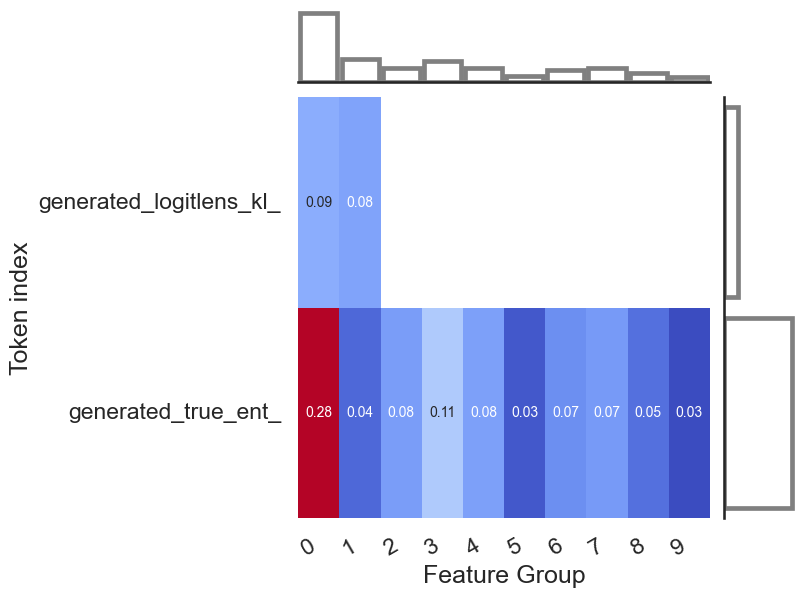

In [65]:
# https://github.com/shap/shap/blob/master/shap/plots/_bar.py
c = shap_values.abs.mean(0)
features = c.display_data if c.display_data is not None else c.data
feature_names = c.feature_names
op_history = c.op_history
values = np.array([c.values])
vals = pd.DataFrame({'label':shap_values.feature_names, 'value':values[0]}).sort_values('value', ascending=False)
vals.value = vals.value / vals.value.sum()
vals['label_orig'] = vals['label']
vals['grp'] = vals['label'].apply(lambda x : ''.join(i for i in x if not i.isdigit()))
# vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x if i.isdigit()))
vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x.split('_')[-1] if i.isdigit()))
vals['label'] = vals['label'].astype(int)

vals.groupby('grp').value.sum()

_toplot = vals.pivot_table(index=['grp'], columns='label', values='value', aggfunc='sum')

grid = sns.JointGrid()

# Fill the centre with our heatmap
sns.heatmap(_toplot, ax=grid.ax_joint, cbar=False, annot=True, fmt=".2f", annot_kws={"fontsize":10}, cmap="coolwarm")
# Draw total bars, both with width 1, but the Y one with horizontal orientation

sns.barplot(_toplot.sum(), ax=grid.ax_marg_x, width=0.9, fill=False, color='grey')

sns.barplot(_toplot.sum(axis=1), ax=grid.ax_marg_y, orient='h', width=0.9, fill=False, color='grey')

# Offset value (just half an unit)
_off = .5

# Fix x
_xmin, _xmax = grid.ax_joint.get_xlim()
grid.ax_joint.set_xlim(_xmin+_off, _xmax+_off)
for bar in grid.ax_marg_x.containers[0]:
    bar.set_x(bar.get_x() + _off)

# Fix y
_ymin, _ymax = grid.ax_joint.get_ylim()
grid.ax_joint.set_ylim(_ymin+_off, _ymax+_off)
for bar in grid.ax_marg_y.containers[0]:
    bar.set_y(bar.get_y() + _off)

# Need to use this to set the horizontal_alignment
grid.ax_joint.set_xticklabels(
    grid.ax_joint.get_xticklabels(), 
    rotation=30,    
    ha='right'
)
grid.ax_joint.yaxis.set_tick_params(rotation=0)

grid.ax_joint.set_xlabel('Feature Group')
grid.ax_joint.set_ylabel('Token index')

### increasing number of cases

In [66]:
ds.pid.nunique()

494

In [67]:
# beginning of generation
N = 10

selected_features = ['true_ent', 'maxp']

# beginning of generation bears more information (AUC) than end of generation
ds = mmg[(mmg.segment=='generated') & (mmg.tokzero<N)][['run', 'pid', 'tokzero'] + selected_features]

ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=selected_features).reset_index()

# indexes for kl/iou are _LAYER_TOKEN
ds.columns = ['_'.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.rename(columns={'run_': 'run', 'pid_': 'pid'})
ds = ds.merge(truth, on=['run', 'pid'])

target = 'answers_entropy_norm' # 'pe_rao_trans_s' # 'answers_entropy_norm'
ds = ds.merge(aggrodue[['pid', target, 'correct_mean']], on='pid')

# WARNING here we are dropping duplicates 
# include pid to have at least one example per prompt
# (include correct as variable since it embeds 'aleatoric uncertainty')
ds = ds.drop_duplicates(ds.columns[1:-3])

y = ds[target].round(2)
correct_mean = ds.correct_mean > 0.5
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated', target, 'correct_mean'])

#X_res, y_res = X, y # rus.fit_resample(X, y)
#pids_res = pids # [y_res.index]

# X_res.columns = ['generated_'+col for col in X.columns]

In [68]:
group_kfold = GroupKFold(n_splits=10)

foldlist = []

for i, (train_index, test_index) in enumerate(group_kfold.split(X, y, pids)):
    foldlist.append(test_index)

In [69]:
# %%time

prog = []

# cycle all
for i, idxs in enumerate(foldlist):
    print(i)
    
    test_idx = idxs
    
    # cycle all, skipping i
    train_idx = set()
    c = 0
    
    # tutti gli id fuorché la fold corrente
    foldlist_ = [idxs_ for (j, idxs_) in enumerate(foldlist) if i != j]
    fold_train_idx = np.concatenate(foldlist_)
    
    # cycle all available pids
    fold_pids = pids.iloc[fold_train_idx]
    
    for pid in tqdm(fold_pids.unique()):
        
        # enlarge dataset one pid at a time
        train_idx = set(train_idx) | set(fold_train_idx[fold_pids == pid]) 
        train_idx = list(train_idx)

        xgb_model = XGBRFRegressor(n_estimators=100, n_jobs=6)
        xgb_model.fit(X.iloc[train_idx], y.iloc[train_idx])

        pred = xgb_model.predict(X.iloc[test_idx])
        
        # always test on out-of-fold data
        met = assessme(y.iloc[test_idx].values, pred)

        prog.append((i, c, len(train_idx), met['mae'], met['mse'], met['rmse'], met['r2']))
        c += 1
            

0


100%|█████████████████████████████████████████| 445/445 [01:04<00:00,  6.87it/s]


1


100%|█████████████████████████████████████████| 445/445 [01:14<00:00,  6.01it/s]


2


100%|█████████████████████████████████████████| 445/445 [01:27<00:00,  5.07it/s]


3


100%|█████████████████████████████████████████| 445/445 [01:29<00:00,  4.97it/s]


4


100%|█████████████████████████████████████████| 444/444 [01:37<00:00,  4.56it/s]


5


100%|█████████████████████████████████████████| 444/444 [01:46<00:00,  4.17it/s]


6


100%|█████████████████████████████████████████| 444/444 [01:44<00:00,  4.23it/s]


7


100%|█████████████████████████████████████████| 444/444 [01:48<00:00,  4.09it/s]


8


100%|█████████████████████████████████████████| 445/445 [01:45<00:00,  4.24it/s]


9


100%|█████████████████████████████████████████| 445/445 [00:33<00:00, 13.31it/s]


In [71]:
prog_ = pd.DataFrame(prog, columns=['i', 'c', 'n', 'mae', 'mse', 'rmse', 'r2'])

In [72]:
prog_.shape

(4446, 7)

In [73]:
prog_

,i,c,n,mae,mse,rmse,r2
0,0,0,1,0.353377,0.211658,0.460064,-1.438928
1,0,1,2,0.353377,0.211658,0.460064,-1.438928
2,0,2,3,0.353377,0.211658,0.460064,-1.438928
3,0,3,5,0.261559,0.122405,0.349864,-0.410466
4,0,4,7,0.214235,0.085460,0.292336,0.015248
...,...,...,...,...,...,...,...
4441,9,440,686,0.143330,0.028793,0.169685,0.618210
4442,9,441,688,0.145118,0.030502,0.174647,0.595551
4443,9,442,689,0.148064,0.031213,0.176673,0.586116
4444,9,443,691,0.147622,0.031049,0.176207,0.588293


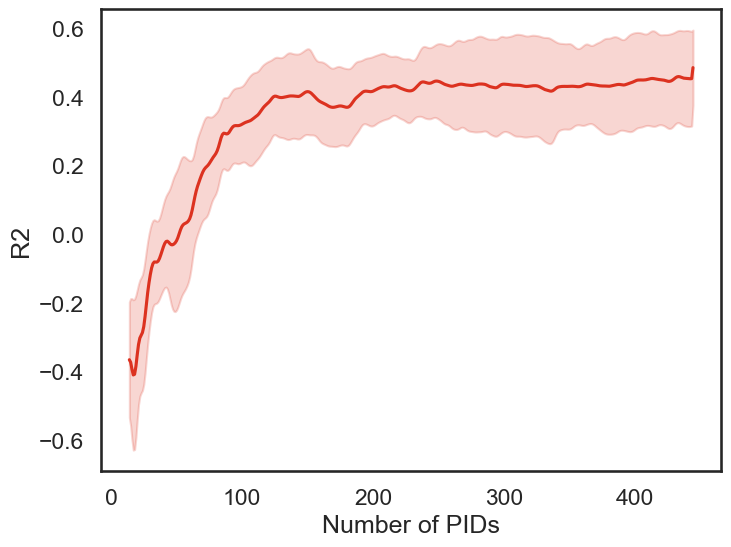

In [74]:
def smooth_data(df, column, window=10):
    return df.groupby("i")[column].transform(lambda x: x.rolling(window, win_type="gaussian").mean(std=2))

prog_["mae_smooth"] = smooth_data(prog_, "mae", window=15)
prog_["r2_smooth"] = smooth_data(prog_, "r2", window=15)

plt.figure(figsize=(8, 6))
sns.lineplot(prog_, x="c", y="r2_smooth", errorbar="sd", color='#DC3220')
# plt.title("Entropy regression MAE over number of PIDs in training")
plt.xlabel("Number of PIDs")
plt.ylabel("R2")
plt.show()

<Axes: xlabel='c', ylabel='mae'>

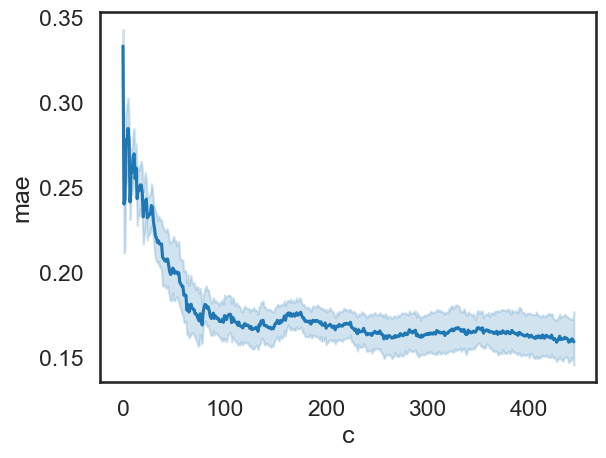

In [75]:
# x = #pids
sns.lineplot(prog_, x='c', y='mae')

<Axes: xlabel='c', ylabel='mae'>

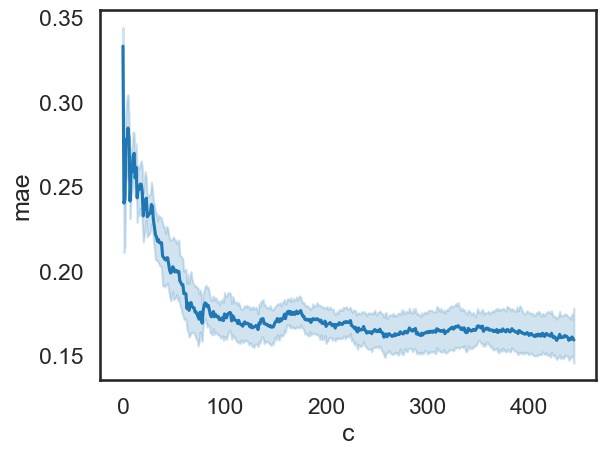

In [76]:
# x = #pids
sns.lineplot(prog_, x='c', y='mae')

### beginning of generation, accuracy

In [77]:
%%time

from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict

from xgboost import XGBRFRegressor, XGBRFClassifier
import xgboost


xgb_model = XGBRFRegressor(n_estimators=100, n_jobs=6)

pred = cross_val_predict(xgb_model, X_res, correct_mean, cv=GroupKFold(n_splits=10), groups=pids_res)

CPU times: user 3.61 s, sys: 1.52 s, total: 5.12 s
Wall time: 699 ms


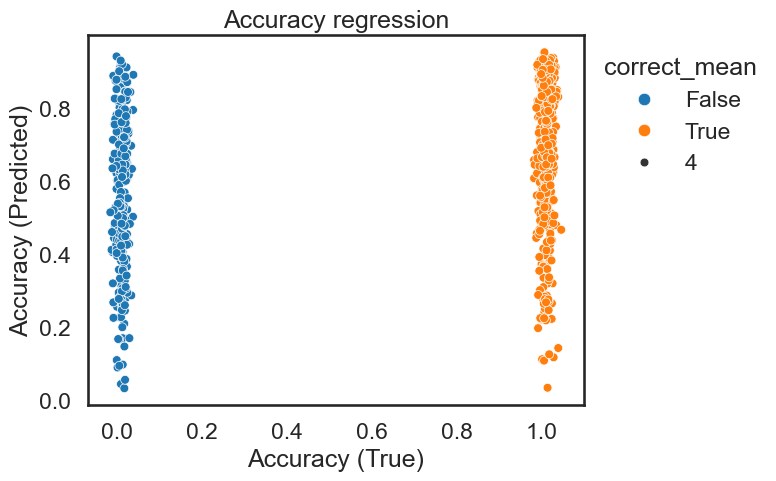

In [78]:
import matplotlib.pyplot as plt

def jitter(values,j):
    return values + np.random.normal(j,0.01,values.shape)

ax = sns.scatterplot(y=jitter(pred,0.01), x=jitter(correct_mean.values, 0.01), hue=correct_mean, size=4)

plt.title('Accuracy regression')
plt.xlabel('Accuracy (True)')
plt.ylabel('Accuracy (Predicted)')

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False)
plt.show()

In [79]:
met = assessme(correct_mean.values, pred)

In [80]:
import xgboost
import shap

model = xgboost.XGBRegressor(n_estimators=100).fit(X_res, correct_mean)
explainer = shap.Explainer(model, X_res)
shap_values = explainer(X_res)

In [81]:
# https://github.com/shap/shap/blob/master/shap/plots/_bar.py
c = shap_values.abs.mean(0)
features = c.display_data if c.display_data is not None else c.data
feature_names = c.feature_names
op_history = c.op_history
values = np.array([c.values])
vals = pd.DataFrame({'label':shap_values.feature_names, 'value':values[0]}).sort_values('value', ascending=False)
vals.value = vals.value / vals.value.sum()
vals['label_orig'] = vals['label']
vals['grp'] = vals['label'].apply(lambda x : ''.join(i for i in x if not i.isdigit()))
vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x if i.isdigit()))
vals['label'] = vals['label'].astype(int)

In [82]:
vals.groupby('grp').value.sum()

grp
generated_logitlens_kl_    0.29748
generated_true_ent_        0.70252
Name: value, dtype: float64



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


The palette list has fewer values (10) than needed (15) and will cycle, which may produce an uninterpretable plot.


<Axes: xlabel='label', ylabel='value'>

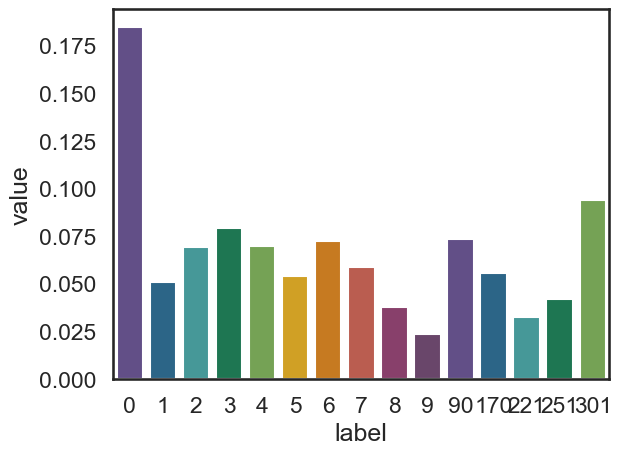

In [83]:
from palettable.cartocolors.qualitative import Prism_10, Bold_10
palette = Prism_10.mpl_colors 

index_importances = vals.sort_index().groupby('label').value.sum()

sns.barplot(index_importances, palette=palette)

### postilla

In [84]:
# all postilla
ds = mm[(mm.segment=='postilla')][['run', 'pid', 'tokzero_end', 'shape', 'true_ent', 'maxp']]
ds = ds.pivot(index=['run', 'pid'], columns='tokzero_end', values=['shape', 'maxp', 'true_ent']).reset_index()
ds.columns = [''.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.merge(truth, on=['run', 'pid'])

# WARNING here we are dropping duplicates (include correct as variable)
ds = ds.merge(aggrodue[['pid', 'answers_entropy_norm', 'correct_mean']], on='pid')
ds = ds.drop_duplicates(ds.columns[1:-3])

y = ds.answers_entropy_norm
correct_mean = ds.correct_mean
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated', 'answers_entropy_norm', 'correct_mean'])

# rus = RandomUnderSampler(random_state=42)
X_res, y_res = X, y # rus.fit_resample(X, y)
pids_res = pids # [y_res.index]

y_res_postilla = y_res
X_res.columns = ['postilla_'+col for col in X.columns]

In [85]:
%%time

from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict

from xgboost import XGBRFRegressor, XGBRFClassifier
import xgboost


xgb_model = XGBRFRegressor(n_estimators=100, n_jobs=6)

pred_postilla = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), groups=pids_res)

CPU times: user 19.5 s, sys: 3.59 s, total: 23.1 s
Wall time: 3.76 s


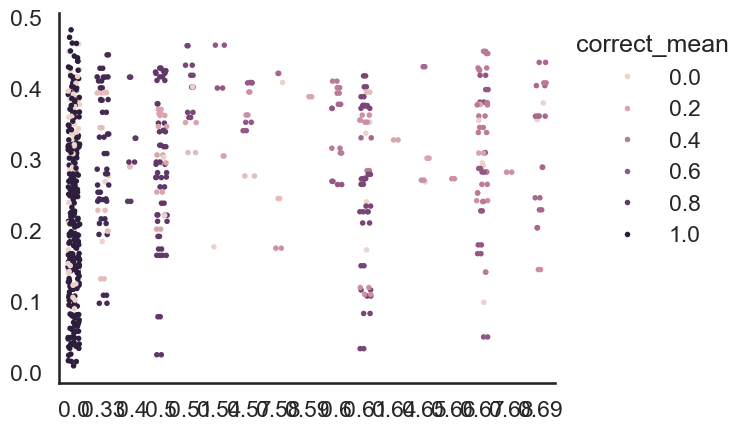

In [86]:
ax = sns.stripplot(y=pred_postilla, x=np.round(y_res_postilla.values,2), jitter=0.2, hue=correct_mean, size=4) # , log_scale=(True,False))
sns.despine()

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False)
plt.show()